In [4]:
from IMPS.utils import build_block_Sigma, C_from_Sigma, sample_PLN, MSE
import torch
from IMPS.model import PLN, show, log_likelihood
from fastPLN import fastPLN
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math


device  cpu
device :  cpu


In [5]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else : 
    device = torch.device('cpu')
print('device ', device)

device  cpu


### Simulation of the data 

In [8]:
d = 3
n = 200;  p = 10
q = 10

In [11]:
# 0 est pas mal 
#torch.manual_seed(0)
Sigma_sampling = 1*torch.from_numpy(build_block_Sigma(p,p//4))/1.5 #+ 0.5*torch.eye(p)
true_C = torch.from_numpy(C_from_Sigma(Sigma_sampling, q))
true_Sigma_sampling = true_C@(true_C.T)
true_beta =torch.randn((d, p))/3

covariates = torch.randn((n,d))
O =  0+torch.zeros((n,p))
#sample_model = sample_PLN()
Y, Z, _  = sample_PLN(Sigma_sampling,true_beta, O, covariates)
Y = torch.from_numpy(Y).to(device)
covariates.to(device)
O.to(device)
None

/home/bastien/Documents/These/PLNpy/IMPS/utils.py:179: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A.transpose(-2, -1).conj()).transpose(-2, -1).conj() (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:1284.)
  chol = torch.cholesky(Sigma)


## fitting the IMPS based model

In [16]:
batch_size = 20
IMPS_model = PLN(q, nb_average_param = 15, nb_average_likelihood = 6,nb_plateau = 10)
%time IMPS_model.fit(Y,O,covariates,150, acc = 0.006)

 19%|█▊        | 28/150 [00:10<00:44,  2.76it/s]

Algorithm stopped after  28  iterations
CPU times: user 40.5 s, sys: 283 ms, total: 40.7 s
Wall time: 10.2 s


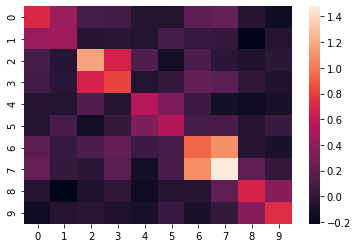

In [19]:
IMPS_model.show_Sigma()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


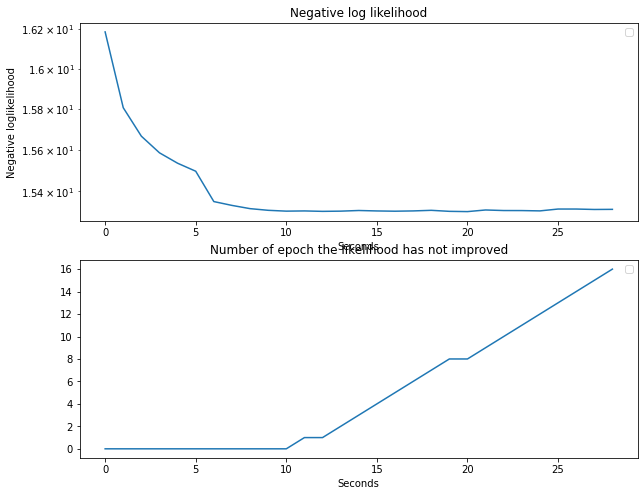

In [18]:
show(IMPS_model)

In [ ]:
fastModel.show_Sigma()
plt.show()
sns.heatmap(fastModel.C@(fastModel.C.T))

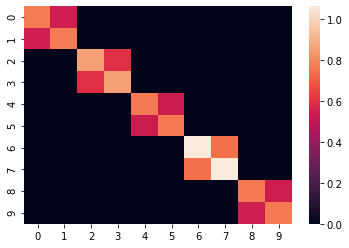

In [20]:
sns.heatmap(true_Sigma_sampling)
plt.show()

In [21]:
print('MSE beta', MSE(IMPS_model.beta_mean-true_beta))
print('MSE Sigma', MSE(IMPS_model.Sigma()-true_Sigma_sampling))

MSE beta tensor(0.0824)
MSE Sigma tensor(0.1927)


No handles with labels found to put in legend.
No handles with labels found to put in legend.


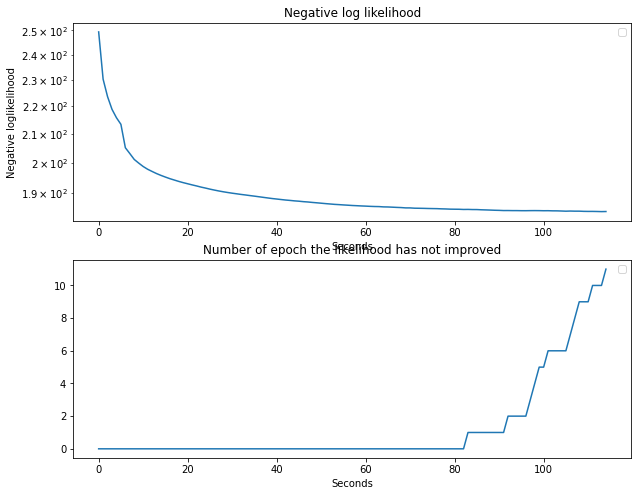

In [22]:
show(IMPS_model)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


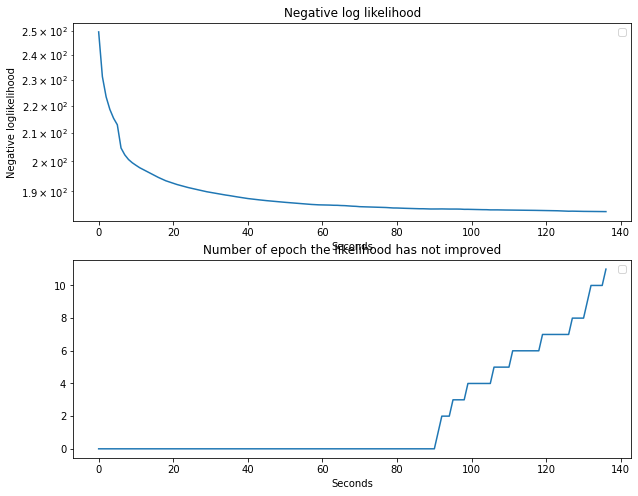

In [31]:
show(IMPS_model)

## fitting the Variational model

In [21]:
fastModel = fastPLN()
fastModel.fit(Y,O,covariates, 200)
fastModel.C = torch.from_numpy(C_from_Sigma(fastModel.Sigma.detach(), q)).detach()

## Computing the likelihoods

In [22]:
log_like_IMPS_list = list()
log_like_fast_list = list()
for i in range(1): 
    log_like_IMPS_list.append(log_likelihood(Y,O,covariates, IMPS_model.C_mean, IMPS_model.beta_mean, acc = 0.05).detach().item())
    log_like_fast_list.append(log_likelihood(Y,O,covariates, fastModel.C, fastModel.beta.detach(), acc = 0.05).detach().item())

NameError: name 'IMPS_PLN' is not defined

## comparing both likelihoods

/home/bbatardiere/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/bbatardiere/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/bbatardiere/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/bbatardiere/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py

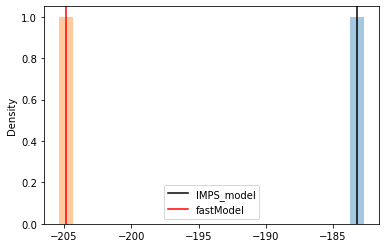

In [34]:
log_like_IMPS = np.mean(np.array(log_like_IMPS_list))
log_like_fast = np.mean(np.array(log_like_fast_list))


sns.distplot(np.array(log_like_IMPS_list))
plt.axvline(log_like_IMPS, label = 'IMPS_model', c = 'black')

sns.distplot(np.array(log_like_fast_list))
plt.axvline(log_like_fast, label = 'fastModel', c = 'red')
plt.legend()

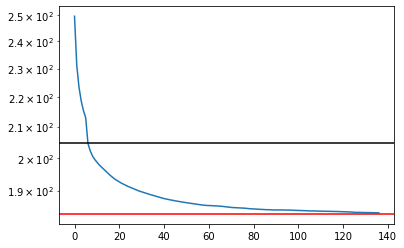

In [36]:
l = IMPS_model.log_likelihood_list
plt.plot(np.arange(0, len(l)), - np.array(l))

plt.axhline(-log_like_fast, c = 'black')
plt.axhline(-log_like_IMPS, c = 'red')
plt.yscale('log')

## Comparing the MSEs  

In [37]:
print('MSE beta for IMPS', MSE(IMPS_model.beta_mean-true_beta))
print('MSE beta for Var App', MSE(fastModel.beta-true_beta).detach())

MSE beta for IMPS tensor(0.0715)
MSE beta for Var App tensor(0.0165)


In [38]:
print('MSE Sigma for IMPS: ', MSE(IMPS_model.Sigma()-true_Sigma_sampling))
print('MSE Sigma for IMPS: ', MSE(fastModel.Sigma-true_Sigma_sampling))

MSE Sigma for IMPS:  tensor(0.1909)
MSE Sigma for IMPS:  tensor(0.0665, grad_fn=<MeanBackward0>)


## additional 

In [34]:
print(MSE(IMPS_model.beta_mean-true_beta))
print(MSE(IMPS_model.beta-true_beta))
print(MSE(IMPS_model.Sigma()- true_Sigma_sampling))
print(MSE((IMPS_model.C@IMPS_model.C.T)-true_Sigma_sampling))

tensor(0.0051)
tensor(0.0051, grad_fn=<MeanBackward0>)
tensor(0.0433)
tensor(0.0448, grad_fn=<MeanBackward0>)


In [35]:
IMPS_model.beta_mean

tensor([[-4.2995e-02,  1.4011e-01, -4.1408e-01,  5.7551e-03, -1.0687e-01,
         -4.6650e-01, -4.2465e-01,  7.8986e-02,  4.0549e-01, -4.7068e-01,
         -4.1786e-01, -2.2352e-01, -1.9917e-01,  8.6350e-01,  5.4368e-01,
         -7.2152e-02,  4.6854e-01,  7.7282e-01,  3.0317e-01,  5.7381e-01,
          3.4583e-01,  6.8890e-01,  2.9446e-01,  2.6742e-01,  4.3887e-01,
         -1.8218e-01, -1.4808e-02, -7.7387e-03,  5.1723e-03,  1.5539e-01,
          3.5229e-01,  2.3994e-01,  5.3226e-01, -5.9380e-01, -1.9871e-01,
          3.4108e-01,  4.4736e-01, -1.0495e-02, -1.6037e-01, -1.6108e-01,
         -2.1306e-01, -2.2988e-01,  2.3285e-01, -1.3248e-01,  4.3287e-01,
          6.8753e-01, -1.8264e-02, -1.6492e-01,  4.2250e-01,  3.1361e-01,
         -1.3262e-01,  6.0375e-02,  1.4002e-02,  3.1982e-01,  2.4919e-01,
          3.4656e-01, -1.8159e-01, -4.4648e-01, -9.9878e-02,  5.3317e-02,
          4.4652e-01,  4.3501e-01, -5.2222e-02, -2.3792e-02,  2.0964e-01,
         -2.1938e-01, -6.5044e-01, -1.

In [36]:
true_beta

tensor([[-1.1644e-01,  1.1722e-01, -5.2990e-01, -7.1775e-02, -1.1452e-01,
         -4.4224e-01, -3.4904e-01,  3.7265e-02,  3.5723e-01, -4.2333e-01,
         -4.6506e-01, -2.9983e-01, -2.1870e-01,  7.5900e-01,  4.3989e-01,
         -1.7023e-01,  3.1625e-01,  5.2177e-01,  1.3502e-01,  3.9810e-01,
          2.0435e-01,  5.9238e-01,  2.3352e-01,  2.4914e-01,  4.5444e-01,
         -1.8954e-01, -1.0180e-02, -3.7389e-02, -1.3363e-01,  1.2851e-01,
          3.1765e-01,  2.2889e-01,  4.9238e-01, -6.5377e-01, -1.8661e-01,
          3.5880e-01,  4.0051e-01,  1.2025e-02, -1.7191e-01, -1.9187e-01,
         -2.5920e-01, -3.0213e-01,  2.0843e-01, -1.1795e-01,  3.5241e-01,
          4.9276e-01, -7.7064e-02, -2.3672e-01,  3.6729e-01,  2.9998e-01,
         -1.4670e-01,  5.4048e-03,  5.0838e-03,  3.3024e-01,  2.5163e-01,
          3.9649e-01, -1.5534e-01, -4.3829e-01, -5.9374e-02,  8.8648e-02,
          4.6414e-01,  4.7064e-01, -8.0573e-03, -4.2897e-02,  2.1287e-01,
         -2.1086e-01, -6.5799e-01, -1.

var_chap tensor([1.1209, 1.1184, 0.9064, 1.1695, 1.1597, 0.8897])
var_chap tensor([1.1209, 1.1184, 0.9064, 1.1695, 1.1597, 0.8897])


tensor([1.1209, 1.1184, 0.9064, 1.1695, 1.1597, 0.8897])

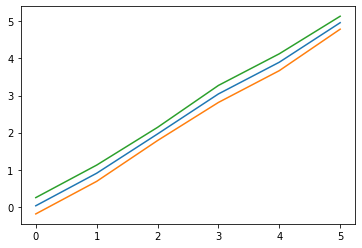

In [110]:
def S_n(X): 
    X_barre = torch.mean(X, axis = 0)
    n = X.shape[0]
    return torch.sum((X-X_barre)**2, axis = 0)/(n-1)

def get_border(X):
    var_chap = S_n(X)
    t = 1.96
    n = X.shape[0]
    return t*var_chap/math.sqrt(n)



N = 100
X = torch.randn(N,6)+ (torch.arange(6)**1).unsqueeze(0)
X_barre = torch.mean(X, axis = 0)
abs_ = np.arange(6)
plt.plot(abs_, X_barre)
plt.plot(abs_, X_barre-get_border(X))
plt.plot(abs_, X_barre+get_border(X))

S_n(X)